In [58]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt

In [59]:
data = pd.read_csv("measurements_.csv")

# Subtract start time.
start = data.t.values[0]
data.t -= start
# To ms.
data.t /= 1000000
# data.t.values[0]
data.head()

,t,vout,code,vout_meas,vref
0,0.0000,0.0000,0.0,0.000008,4.578881
1,21.5119,0.0005,0.0,0.000008,4.578223
2,42.5215,0.0010,0.0,0.000666,4.582169
3,63.5100,0.0015,0.0,0.001324,4.579538
4,84.5075,0.0020,0.0,0.001981,4.579867


First of all, let's compute the measured input voltage using the reference voltage values.

In the most exact case, we can calculate each value separately when we know all the reference voltages during all the measurements.
However, it might also be reasonable to perform the analysis after averaging this column, since the actual end user might not monitor the reference voltage constantly during measurements.

In [60]:
res = 2 ** 10
data["vin"] = data.code * data.vref / res
data[5000:6000]

vref = np.mean(data.vref)
print(vref)

4.577298216126094


Let's try to find the last transition

In [61]:
last_transition_v = data.vref / res * (res - 1)
print(last_transition_v)
last_transition = data[data.vout >= last_transition_v].iloc[0].name

# Keep only the data up until the last transition.
data = data[:last_transition]
print(len(data))

0       4.574409
1       4.573752
2       4.577694
3       4.575066
4       4.575395
          ...   
9995    4.571453
9996    4.574081
9997    4.570467
9998    4.570796
9999    4.571453
Name: vref, Length: 10000, dtype: float64
9143


## Calculate the statistics.

Coefficient = 223.7127562264541.
LinregressResult(slope=1.0002014926310616, intercept=-0.0028177218460707643, rvalue=0.9999977861518903, pvalue=0.0, stderr=2.2013052698461227e-05, intercept_stderr=5.810134349798622e-05)
0.0044700177891856385
Offset error = 0.6301326070715356 LSB, full-scale error: 0.4242486222323212 LSB, gain error = 0.2058839848392145 LSB.


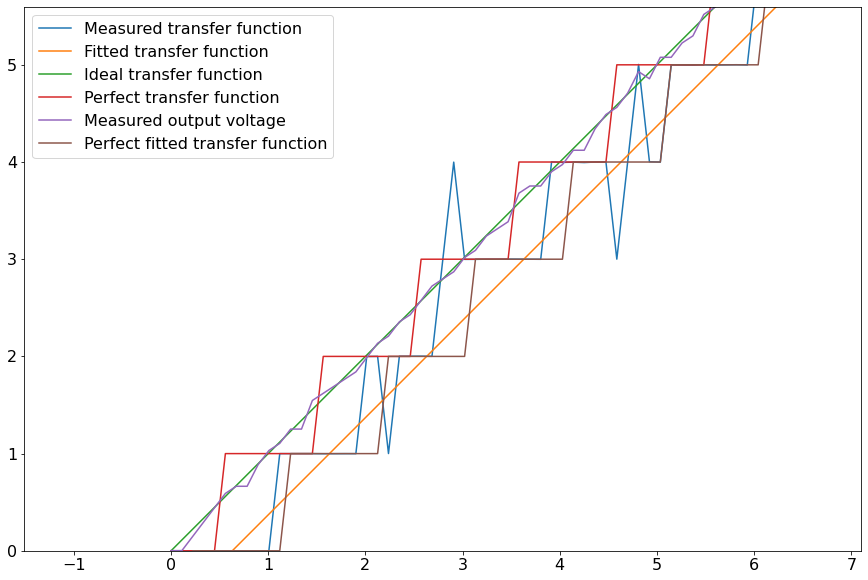

In [62]:
from scipy.stats import linregress

def v_to_code(voltage):
    global res, vref
    return voltage * res / vref

def perfect_adc_code(voltage):
    global res, vref
    return np.round(voltage * res / vref) / (res / vref)  # "/ (res / vref)" just because it will be scaled later on.

code = True
if code:
    coef = res / vref
else:
    coef = 1
print(f"Coefficient = {coef}.")


# Perform linear regression using least squares.
lr = linregress(x=data.vout, y=data.vin)
print(lr)

fig, ax = plt.subplots(figsize=(15, 10))

# print(perfect_adc_code(data.vout))
# print(v_to_code(data.vout))

ax.axis("equal")
# Plot the voltages.
limits = [0 * coef, 0.025 * coef]
# limits = [1000, 1023]
# limits = [0, 1024]
ax.plot(data.vout * coef, data.vin * coef, label="Measured transfer function")
ax.plot(data.vout * coef, (lr.slope * data.vout + lr.intercept) * coef, label="Fitted transfer function")
ax.plot(data.vout * coef, data.vout * coef, label="Ideal transfer function")
ax.plot(data.vout * coef, perfect_adc_code(data.vout) * coef, label="Perfect transfer function")
ax.plot(data.vout * coef, data.vout_meas * coef, label="Measured output voltage")
ax.plot(data.vout * coef, perfect_adc_code(lr.slope * data.vout + lr.intercept) * coef, label="Perfect fitted transfer function")

# Set the limits to display only a part of the plot.
ax.set_xlim(limits)
ax.set_ylim(limits)

# Set the legend.
ax.legend()

# Calculate offset and gain errors.
lsb_v = vref / res
print(lsb_v)

def calculate_fit_error(lsbs, lsb_v, slope, intercept, verbose=False):
    offset_y = lsbs * lsb_v
    ideal_x = offset_y
    offset_x = (offset_y - intercept) / slope
    if verbose:
        print(f"Offset_x: {offset_x * coef}, offset_y (==ideal_x): {offset_y}.")
    return offset_x - ideal_x

# Offset error calculated at 0.5 LSB.
offset_error_v = calculate_fit_error(0.5, lsb_v, lr.slope, lr.intercept)
# Full-scale error calculated at MAX - 1.5 LSB.
fs_error_v = calculate_fit_error(res - 1.5, lsb_v, lr.slope, lr.intercept)
# Gain error
gain_error_v = -(fs_error_v - offset_error_v)

offset_error = offset_error_v * coef
fs_error = fs_error_v * coef
gain_error = gain_error_v * coef
print(f"Offset error = {offset_error} LSB, full-scale error: {fs_error} LSB, gain error = {gain_error} LSB.")

# plt.show()
# plt.savefig("errors.pdf")

In [63]:
# Missing codes?
print(data.code.astype("category").unique())

# Since finding the DNL is done using the best-fit line, calculate the perfect codes based on that.
# Also take into account the actual output values (vout_meas).
# Also, do not output negative codes!
data["perfect_code"] = (np.maximum(np.round(perfect_adc_code(lr.slope * data.vout_meas + lr.intercept) * (res / vref)), 0)).astype(int)
data.perfect_code

[0.0, 1.0, 2.0, 3.0, 4.0, ..., 1017.0, 1019.0, 1020.0, 1021.0, 1022.0]
Length: 1023
Categories (1023, float64): [0.0, 1.0, 2.0, 3.0, ..., 1019.0, 1020.0, 1021.0, 1022.0]


C:\Users\Jyri\anaconda3\envs\DAQSP\lib\site-packages\pandas\io\formats\format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


0          0
1          0
2          0
3          0
4          0
        ... 
9138    1022
9139    1022
9140    1022
9141    1022
9142    1022
Name: perfect_code, Length: 9143, dtype: int32

(array([11.,  8., 10., ...,  8.,  8.,  0.]), array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.022e+03, 1.023e+03,
       1.024e+03]), <BarContainer object of 1024 artists>)


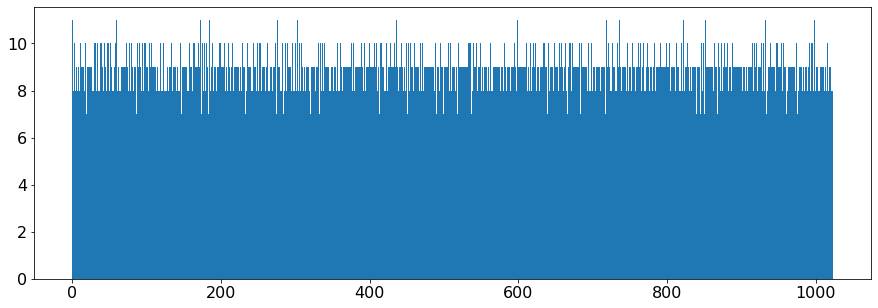

In [64]:
perfect_codes = (np.maximum(np.round(perfect_adc_code(lr.slope * data.vout_meas + lr.intercept) * (res / vref)), 0)).astype(int)

plt.figure(figsize=(15, 5))
perfect_hist = plt.hist(perfect_codes, bins=1024, range=(0, 1024))

print(perfect_hist)

(array([10.,  9.,  6., ..., 11.,  4.,  0.]), array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.022e+03, 1.023e+03,
       1.024e+03]), <BarContainer object of 1024 artists>)


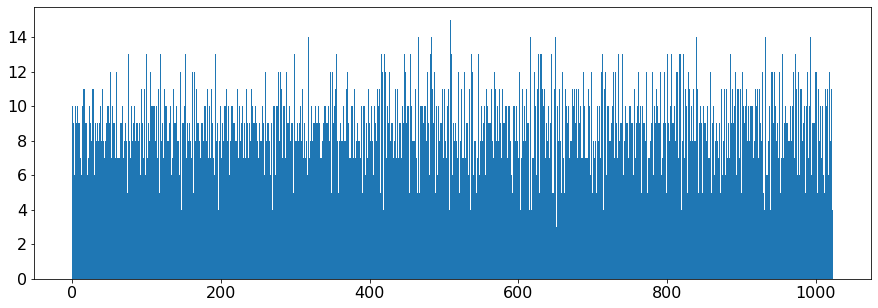

In [65]:
plt.figure(figsize=(15, 5))
real_hist = plt.hist(data.code.astype(int), bins=1024, range=(0, 1024))

print(real_hist)


In [66]:
dnls = real_hist[0] / perfect_hist[0] - 1

print(dnls)
dnl = np.nanmax(np.abs(dnls))
print(np.nanmin(dnls), np.nanmax(dnls))
print(np.nanargmin(dnls), np.nanargmax(dnls))

print(f"Differential non-linearity: {round(dnl, 2)} LSB.")

[-0.09090909  0.125      -0.4        ...  0.375      -0.5
         nan]
-0.7 1.1428571428571428
447 198
Differential non-linearity: 1.14 LSB.


C:\Users\Jyri\AppData\Local\Temp/ipykernel_21536/11002212.py:1: RuntimeWarning: invalid value encountered in true_divide
  dnls = real_hist[0] / perfect_hist[0] - 1


In [67]:
# Calculate integral non-linearities.
print(len(dnls))
inls = np.zeros_like(dnls)
for i in range(len(dnls)):
    inls[i] = np.sum(dnls[:i + 1])

print(inls)
inl = np.nanmax(np.abs(inls))
print(np.nanmin(inls), np.nanmax(inls))
print(np.nanargmin(inls), np.nanargmax(inls))
print(f"Integral non-linearity: {round(inl, 2)} LSB.")

1024
[-0.09090909  0.03409091 -0.36590909 ...  9.04206349  8.54206349
         nan]
-0.3940836940836939 9.217063492063499
25 1014
Integral non-linearity: 9.22 LSB.


In [68]:
# Print out all the errors found so far.
print(
f"""Offset error = {round(offset_error, 2)} LSB, 
Full-scale error: {round(fs_error, 2)} LSB, 
Gain error = {round(gain_error, 2)} LSB,
Differential non-linearity = {round(dnl, 2)} LSB,
Integral non-linearity = {round(inl, 2)} LSB."""
)


Offset error = 0.63 LSB, 
Full-scale error: 0.42 LSB, 
Gain error = 0.21 LSB,
Differential non-linearity = 1.14 LSB,
Integral non-linearity = 9.22 LSB.


Now, also create plots of DNL and INL.

In [69]:
def plot(x=[], y=[], xlabel="", ylabel="", legend="", figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    if len(x) > 0:
        ax.plot(x, y, label=legend)
    else:
        ax.plot(y, label=legend)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

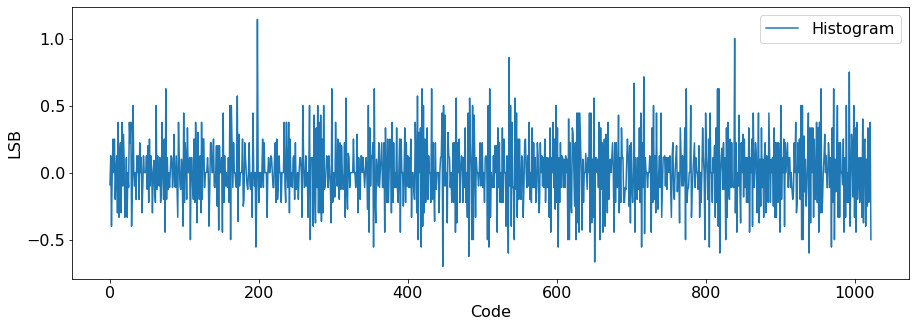

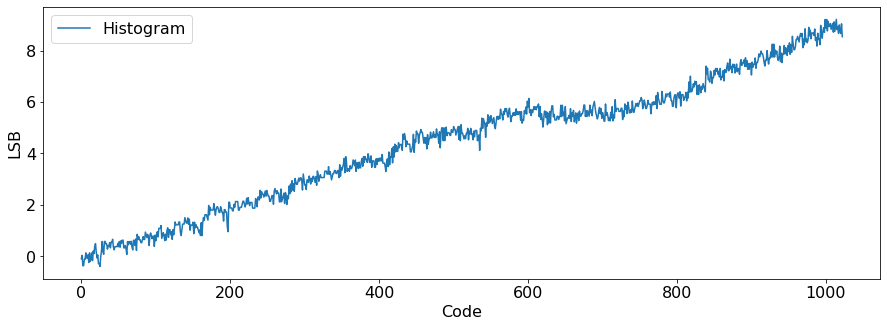

In [70]:
plt.rc("font", size=16)

plot(y=dnls, xlabel="Code", ylabel="LSB", legend="Histogram")
plot(y=inls, xlabel="Code", ylabel="LSB", legend="Histogram")